<a href="https://colab.research.google.com/github/benebobaa/ML-Movie_Recommendation/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Movie Recomendation Engine with Collaborative Filltering Using Spark.**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/MyDrive/spark-3.0.0-bin-hadoop3.2.tgz

!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 16.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=48c3dc8669ef3c20fd6c26d1e65500a4670ca8c0cf9a82e65b53afe9301191c7
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Library

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator            # For RMSE Evaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator   # For tunning hpyperparameter
from pyspark.ml.recommendation import ALS                        # Alternating Least Square
from pyspark.sql.functions import udf, col, when, count, isnan, row_number, window, explode, rand
import random

#Import Dataset from Kaggle

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benediktussatriya","key":"5571ef5062bae925b043b79195cc175c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

 99% 193M/195M [00:08<00:00, 30.7MB/s]
100% 195M/195M [00:08<00:00, 25.4MB/s]


In [ ]:
!unzip /content/movielens-20m-dataset.zip

Archive:  /content/movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


In [ ]:
spark = SparkSession.builder.appName("movie_recomendation").getOrCreate()
print(spark.version)

3.3.1


###Read Dataset and Joining the datasets

In [ ]:
df_rating = spark.read.csv("/content/rating.csv",inferSchema=True, header=True)
df_movie = spark.read.csv("/content/movie.csv",inferSchema=True, header=True)

df_movie_ratings = df_rating.join(df_movie, ['movieId'], 'left')
df_movie_ratings.show(10)

+-------+------+------+-------------------+--------------------+--------------------+
|movieId|userId|rating|          timestamp|               title|              genres|
+-------+------+------+-------------------+--------------------+--------------------+
|      2|     1|   3.5|2005-04-02 23:53:47|      Jumanji (1995)|Adventure|Childre...|
|     29|     1|   3.5|2005-04-02 23:31:16|City of Lost Chil...|Adventure|Drama|F...|
|     32|     1|   3.5|2005-04-02 23:33:39|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|
|     47|     1|   3.5|2005-04-02 23:32:07|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|   3.5|2005-04-02 23:29:40|Usual Suspects, T...|Crime|Mystery|Thr...|
|    112|     1|   3.5|2004-09-10 03:09:00|Rumble in the Bro...|Action|Adventure|...|
|    151|     1|   4.0|2004-09-10 03:08:54|      Rob Roy (1995)|Action|Drama|Roma...|
|    223|     1|   4.0|2005-04-02 23:46:13|       Clerks (1994)|              Comedy|
|    253|     1|   4.0|2005-04-02 23:35:40|Interview w

### Choose query from dataset where userId around 1-10, because the origin datasets heavier

In [ ]:
df_movie_ratings.createOrReplaceTempView("df_view")
df_movie_new = spark.sql(
    """
    SELECT * 
    FROM df_view
    WHERE userId <= 10
    """
)

In [ ]:
df_movie_new.show(10)

+-------+------+------+-------------------+--------------------+--------------------+
|movieId|userId|rating|          timestamp|               title|              genres|
+-------+------+------+-------------------+--------------------+--------------------+
|      2|     1|   3.5|2005-04-02 23:53:47|      Jumanji (1995)|Adventure|Childre...|
|     29|     1|   3.5|2005-04-02 23:31:16|City of Lost Chil...|Adventure|Drama|F...|
|     32|     1|   3.5|2005-04-02 23:33:39|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|
|     47|     1|   3.5|2005-04-02 23:32:07|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|   3.5|2005-04-02 23:29:40|Usual Suspects, T...|Crime|Mystery|Thr...|
|    112|     1|   3.5|2004-09-10 03:09:00|Rumble in the Bro...|Action|Adventure|...|
|    151|     1|   4.0|2004-09-10 03:08:54|      Rob Roy (1995)|Action|Drama|Roma...|
|    223|     1|   4.0|2005-04-02 23:46:13|       Clerks (1994)|              Comedy|
|    253|     1|   4.0|2005-04-02 23:35:40|Interview w

In [ ]:
df_movie_new.describe().show()

+-------+------------------+------------------+------------------+--------------------+----------------+
|summary|           movieId|            userId|            rating|               title|          genres|
+-------+------------------+------------------+------------------+--------------------+----------------+
|  count|               960|               960|               960|                 960|             960|
|   mean|2048.0510416666666| 4.823958333333334|3.7197916666666666|                null|            null|
| stddev| 1927.862911118332|2.7709292603631606|0.9142733077505908|                null|            null|
|    min|                 1|                 1|               1.0|1984 (Nineteen Ei...|Action|Adventure|
|    max|             31696|                10|               5.0|¡Three Amigos! (1...|         Western|
+-------+------------------+------------------+------------------+--------------------+----------------+



In [ ]:
print("Shape of the dataset: ", (df_movie_new.count(), len(df_movie_new.columns)))

Shape of the dataset:  (960, 6)


In [ ]:
df_movie_new.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
#Remove timestamo column from the newest data frame
df_movie_new = df_movie_new.drop("timestamp") 
df_movie_new.show(10)

+-------+------+------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|
+-------+------+------+--------------------+--------------------+
|      2|     1|   3.5|      Jumanji (1995)|Adventure|Childre...|
|     29|     1|   3.5|City of Lost Chil...|Adventure|Drama|F...|
|     32|     1|   3.5|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|
|     47|     1|   3.5|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|   3.5|Usual Suspects, T...|Crime|Mystery|Thr...|
|    112|     1|   3.5|Rumble in the Bro...|Action|Adventure|...|
|    151|     1|   4.0|      Rob Roy (1995)|Action|Drama|Roma...|
|    223|     1|   4.0|       Clerks (1994)|              Comedy|
|    253|     1|   4.0|Interview with th...|        Drama|Horror|
|    260|     1|   4.0|Star Wars: Episod...|Action|Adventure|...|
+-------+------+------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
#checking null value
df_new_null = df_movie_new.select([count(when(col(c).contains("None")|col(c).contains("NULL")|(col(c) =="")|col(c).isNull()|isnan(c),c)).alias(c)for c in df_movie_new.columns])
df_new_null.show(10)

+-------+------+------+-----+------+
|movieId|userId|rating|title|genres|
+-------+------+------+-----+------+
|      0|     0|     0|    0|     0|
+-------+------+------+-----+------+



#Spliting Data

In [ ]:
# Create test and train set
        #Trainiing = 80%
        #Test = 20%
training_df, test_df = df_movie_new.randomSplit([0.8, 0.2], seed = 2020)

In [ ]:
#Check training_df is not empty
training_df.show(5)

+-------+------+------+----------------+--------------------+
|movieId|userId|rating|           title|              genres|
+-------+------+------+----------------+--------------------+
|      1|     3|   4.0|Toy Story (1995)|Adventure|Animati...|
|      1|     6|   5.0|Toy Story (1995)|Adventure|Animati...|
|      1|     8|   4.0|Toy Story (1995)|Adventure|Animati...|
|      1|    10|   4.0|Toy Story (1995)|Adventure|Animati...|
|      2|     1|   3.5|  Jumanji (1995)|Adventure|Childre...|
+-------+------+------+----------------+--------------------+
only showing top 5 rows



In [ ]:
#Check test_df is not empty
test_df.show(5)

+-------+------+------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|
+-------+------+------+--------------------+--------------------+
|      3|     7|   3.0|Grumpier Old Men ...|      Comedy|Romance|
|      7|     6|   5.0|      Sabrina (1995)|      Comedy|Romance|
|     11|     5|   5.0|American Presiden...|Comedy|Drama|Romance|
|     15|     7|   2.0|Cutthroat Island ...|Action|Adventure|...|
|     16|     7|   3.0|       Casino (1995)|         Crime|Drama|
+-------+------+------+--------------------+--------------------+
only showing top 5 rows



# **Create ALS Parameter, Hyperparameters and Do Modeling**

So here tree important columns we have (rating, user and item). In the case of collaborative filtering, matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.


> 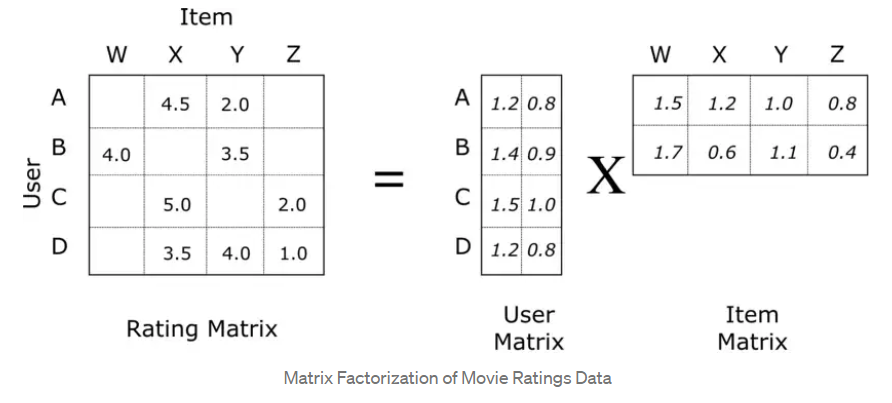


> In the sparse user-item interaction matrix, the predicted rating user u will give item i is computed as:


> 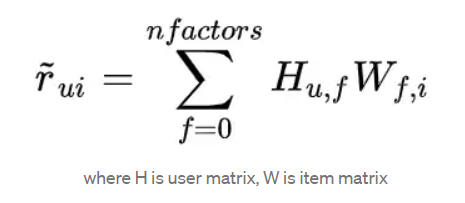

> Rating of item i given by user u can be expressed as a dot product of the user latent vector and the item latent vector.

> Notice in above formula, the number of latent factors can be tuned via cross-validation. Latent factors are the features in the lower dimension latent space projected from user-item interaction matrix. The idea behind matrix factorization is to use latent factors to represent user preferences or movie topics in a much lower dimension space.

In [ ]:
# Create ALS hyperparameters
#As the Text abose, first we need to declare in general. 
                     #userId as User(userCol), movieId as Item(itemCol) and rating as (ratingCol). 

# nonnegative specifies whether or not to use nonnegative constraints for least squares(defaults to false)
                     #True: Ensures positive numbers

#implicitPrefs set to False(automatically it is True).

#coldStartStrategy = "drop": Addresses issues with test/train split; 
                     # only use users that have ratings in both training and testing set, 
                     # and not to use users that only appear in the testing set to calculate RMSE.
als = ALS(
         userCol="userId", 
         itemCol="movieId",
         ratingCol="rating", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop"
)

In [ ]:
# Add our tunning hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()

> Rank is the the width of the metrices U and P or we can say the number of features in feature vectors. Rank has big corelation to our Root-mean-square deviation(RMSE).


In [ ]:
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="rating", 
           predictionCol="prediction") 

In [ ]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

The number of folds (also known as numFolds) is a hyperparameter in the k-fold cross-validation technique. It determines the number of partitions or "folds" that the data is divided into for training and testing.

For example, in a 5-fold cross-validation, the data is divided into 5 equal parts, and the model is trained on 4 parts and tested on the remaining 1 part. This process is repeated 5 times, each time using a different part for testing. The performance of the model is then averaged over

Training data

In [ ]:
#Fit cross validator to the 'train' dataset
model = cv.fit(training_df)

#Extract best model from the cv model above
best_model = model.bestModel

# View the predictions
test_predictions = best_model.transform(test_df)

**Evaluation with RMSE**
> Root of the Mean of the Square of Error that predicted by our Regression model: 

> 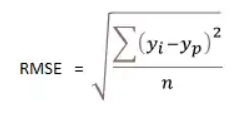

> Yi = actual value

> Yp = predicted Value

> n = number of observations/rows

In [ ]:
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

1.1440822446299546


An RMSE of 1.2 means that on average the model predicts 1.2 above or below values of the original ratings matrix.

#Test the recommendation system

In [ ]:
# Generate n Recommendations for all users
nrecommendations = best_model.recommendForAllUsers(5)
nrecommendations.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    10|[{1221, 4.819483}...|
|     1|[{8507, 4.8259172...|
|     2|[{527, 5.0131445}...|
|     3|[{8507, 5.009408}...|
|     4|[{454, 4.6026206}...|
|     5|[{1196, 4.9843917...|
|     6|[{52, 4.8660207},...|
|     7|[{1077, 4.8193145...|
|     8|[{858, 4.963628},...|
|     9|[{4148, 4.8314543...|
+------+--------------------+



In [ ]:
nrecommendations = nrecommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))
nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|    10|   1221| 4.819483|
|    10|   1247| 4.819483|
|    10|    858|  4.80187|
|    10|    527| 4.716411|
|    10|   1387|4.6602592|
|     1|   8507|4.8259172|
|     1|   4993|4.8259172|
|     1|   5952|4.8259172|
|     1|   7153|4.8259172|
|     1|    858| 4.402533|
+------+-------+---------+



In [ ]:
nrecommendations.join(df_movie, on='movieId').filter('userId = 1').show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|   8507|     1|4.8259172|       Freaks (1932)|  Crime|Drama|Horror|
|   4993|     1|4.8259172|Lord of the Rings...|   Adventure|Fantasy|
|   5952|     1|4.8259172|Lord of the Rings...|   Adventure|Fantasy|
|   7153|     1|4.8259172|Lord of the Rings...|Action|Adventure|...|
|    858|     1| 4.402533|Godfather, The (1...|         Crime|Drama|
+-------+------+---------+--------------------+--------------------+



In [ ]:
df_movie_new.join(df_movie, on='movieId').filter('userId = 10').sort('rating', ascending=False).limit(5).show()

+-------+------+------+--------------------+--------------------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|               title|              genres|
+-------+------+------+--------------------+--------------------+--------------------+--------------------+
|    527|    10|   5.0|Schindler's List ...|           Drama|War|Schindler's List ...|           Drama|War|
|    858|    10|   5.0|Godfather, The (1...|         Crime|Drama|Godfather, The (1...|         Crime|Drama|
|   1221|    10|   5.0|Godfather: Part I...|         Crime|Drama|Godfather: Part I...|         Crime|Drama|
|   1247|    10|   5.0|Graduate, The (1967)|Comedy|Drama|Romance|Graduate, The (1967)|Comedy|Drama|Romance|
|   1387|    10|   5.0|         Jaws (1975)|       Action|Horror|         Jaws (1975)|       Action|Horror|
+-------+------+------+--------------------+--------------------+--------------------+--------------------+



Recommendation system by random user id range 1 to 10

In [ ]:
user = random.randint(1, 10)
nrecommendations.join(df_movie, on='movieId').filter('userId = {}'.format(user)).show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|   4148|     9|4.8314543|     Hannibal (2001)|     Horror|Thriller|
|    858|     9| 4.740382|Godfather, The (1...|         Crime|Drama|
|   1997|     9|  4.60245|Exorcist, The (1973)|      Horror|Mystery|
|   2959|     9| 4.578904|   Fight Club (1999)|Action|Crime|Dram...|
|   3798|     9|4.4432282|What Lies Beneath...|Drama|Horror|Mystery|
+-------+------+---------+--------------------+--------------------+



Recommendation system by best rating prediction random rows

In [ ]:
nrecommendations.join(df_movie, on='movieId').orderBy(rand()).limit(5).show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|    434|     8| 4.835787|  Cliffhanger (1993)|Action|Adventure|...|
|   1077|     7|4.8193145|      Sleeper (1973)|       Comedy|Sci-Fi|
|   1080|     5| 4.874433|Monty Python's Li...|              Comedy|
|   4993|     3| 5.009408|Lord of the Rings...|   Adventure|Fantasy|
|   1247|     6| 4.864808|Graduate, The (1967)|Comedy|Drama|Romance|
+-------+------+---------+--------------------+--------------------+



#Save model and test load model

save model

In [ ]:
path = "bene/movie_recom"
best_model.write().overwrite().save(path)

load model

In [ ]:
from pyspark.ml.recommendation import ALSModel
movie_recom_model = ALSModel.load(path)

test model has loaded

In [ ]:
movie_recom_model.recommendForAllUsers(1).orderBy(rand()).show()

+------+-------------------+
|userId|    recommendations|
+------+-------------------+
|     7|[{3578, 4.8193145}]|
|     1|[{5952, 4.8259172}]|
|     6|  [{52, 4.8660207}]|
|     5|[{1196, 4.9843917}]|
|     4| [{454, 4.6026206}]|
|     3| [{5952, 5.009408}]|
|     2| [{527, 5.0131445}]|
|    10| [{1221, 4.819483}]|
|     8|  [{858, 4.963628}]|
|     9|[{4148, 4.8314543}]|
+------+-------------------+



download model

In [54]:
from google.colab import files
!zip -r /content/bene/movie_model.zip /content/bene/movie_recom
files.download("/content/bene/movie_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Conclusion
The value rating between result predict and actual data from dataset is very close. That mean the prediction is good.